In [24]:
using Interpolations
using DelimitedFiles
using Cubature
using Plots
using LaTeXStrings

In [25]:
kpk = readdlm("test_pk.txt", comments=true)
pk_itp = interpolate((kpk[:,1],), kpk[:,2], Gridded(Linear()));

In [26]:
b = 2
f = 0.7
pk2d = (μ, k) -> (b + μ^2*f)^2*pk_itp(k)

#29 (generic function with 1 method)

In [27]:
kp = (k, μ, αV, ϵ) -> k*sqrt(αV^2*ϵ^2*μ^2 + αV^2/ϵ*(1 - μ^2))
μp = (k, μ, αV, ϵ) -> μ*αV*ϵ/sqrt(αV^2*ϵ^2*μ^2 + αV^2/ϵ*(1 - μ^2))

#33 (generic function with 1 method)

In [28]:
L0 = x -> 1
L2 = x -> (3*x^2 - 1)/2
L4 = x -> (35*x^4 - 30*x^2 + 3)/8

#39 (generic function with 1 method)

In [29]:
function pkprime(kgrid, weight, αV, ϵ)
    Nk = size(kgrid)[1]
    pp = zeros(Nk)
    for i in 1:Nk
        pp[i] = hquadrature(x -> pk2d(μp(kgrid[i], x, αV, ϵ), kp(kgrid[i], x, αV, ϵ))*weight(x), -1, 1, reltol=1e-4)[1]
    end
    return pp
end

pkprime (generic function with 1 method)

In [30]:
function pell(kgrid, αV, ϵ)
    p0 = pkprime(kgrid, L0, αV, ϵ)*1/2
    p2 = pkprime(kgrid, L2, αV, ϵ)*5/2
    p4 = pkprime(kgrid, L4, αV, ϵ)*9/2
    return p0, p2, p4
end
kgrid = collect(range(0.00, 0.20, step=0.01))
αV = 1.00
ϵ = 1.00
p0ref, p2ref, p4ref = pell(kgrid, αV, ϵ)
p0refp, p2refp, p4refp = pell(kgrid .+ 0.001, αV, ϵ)
dp0 = (p0refp .- p0ref)/0.001.*kgrid
dp2 = (p2refp .- p2ref)/0.001.*kgrid
dp4 = (p4refp .- p4ref)/0.001.*kgrid;

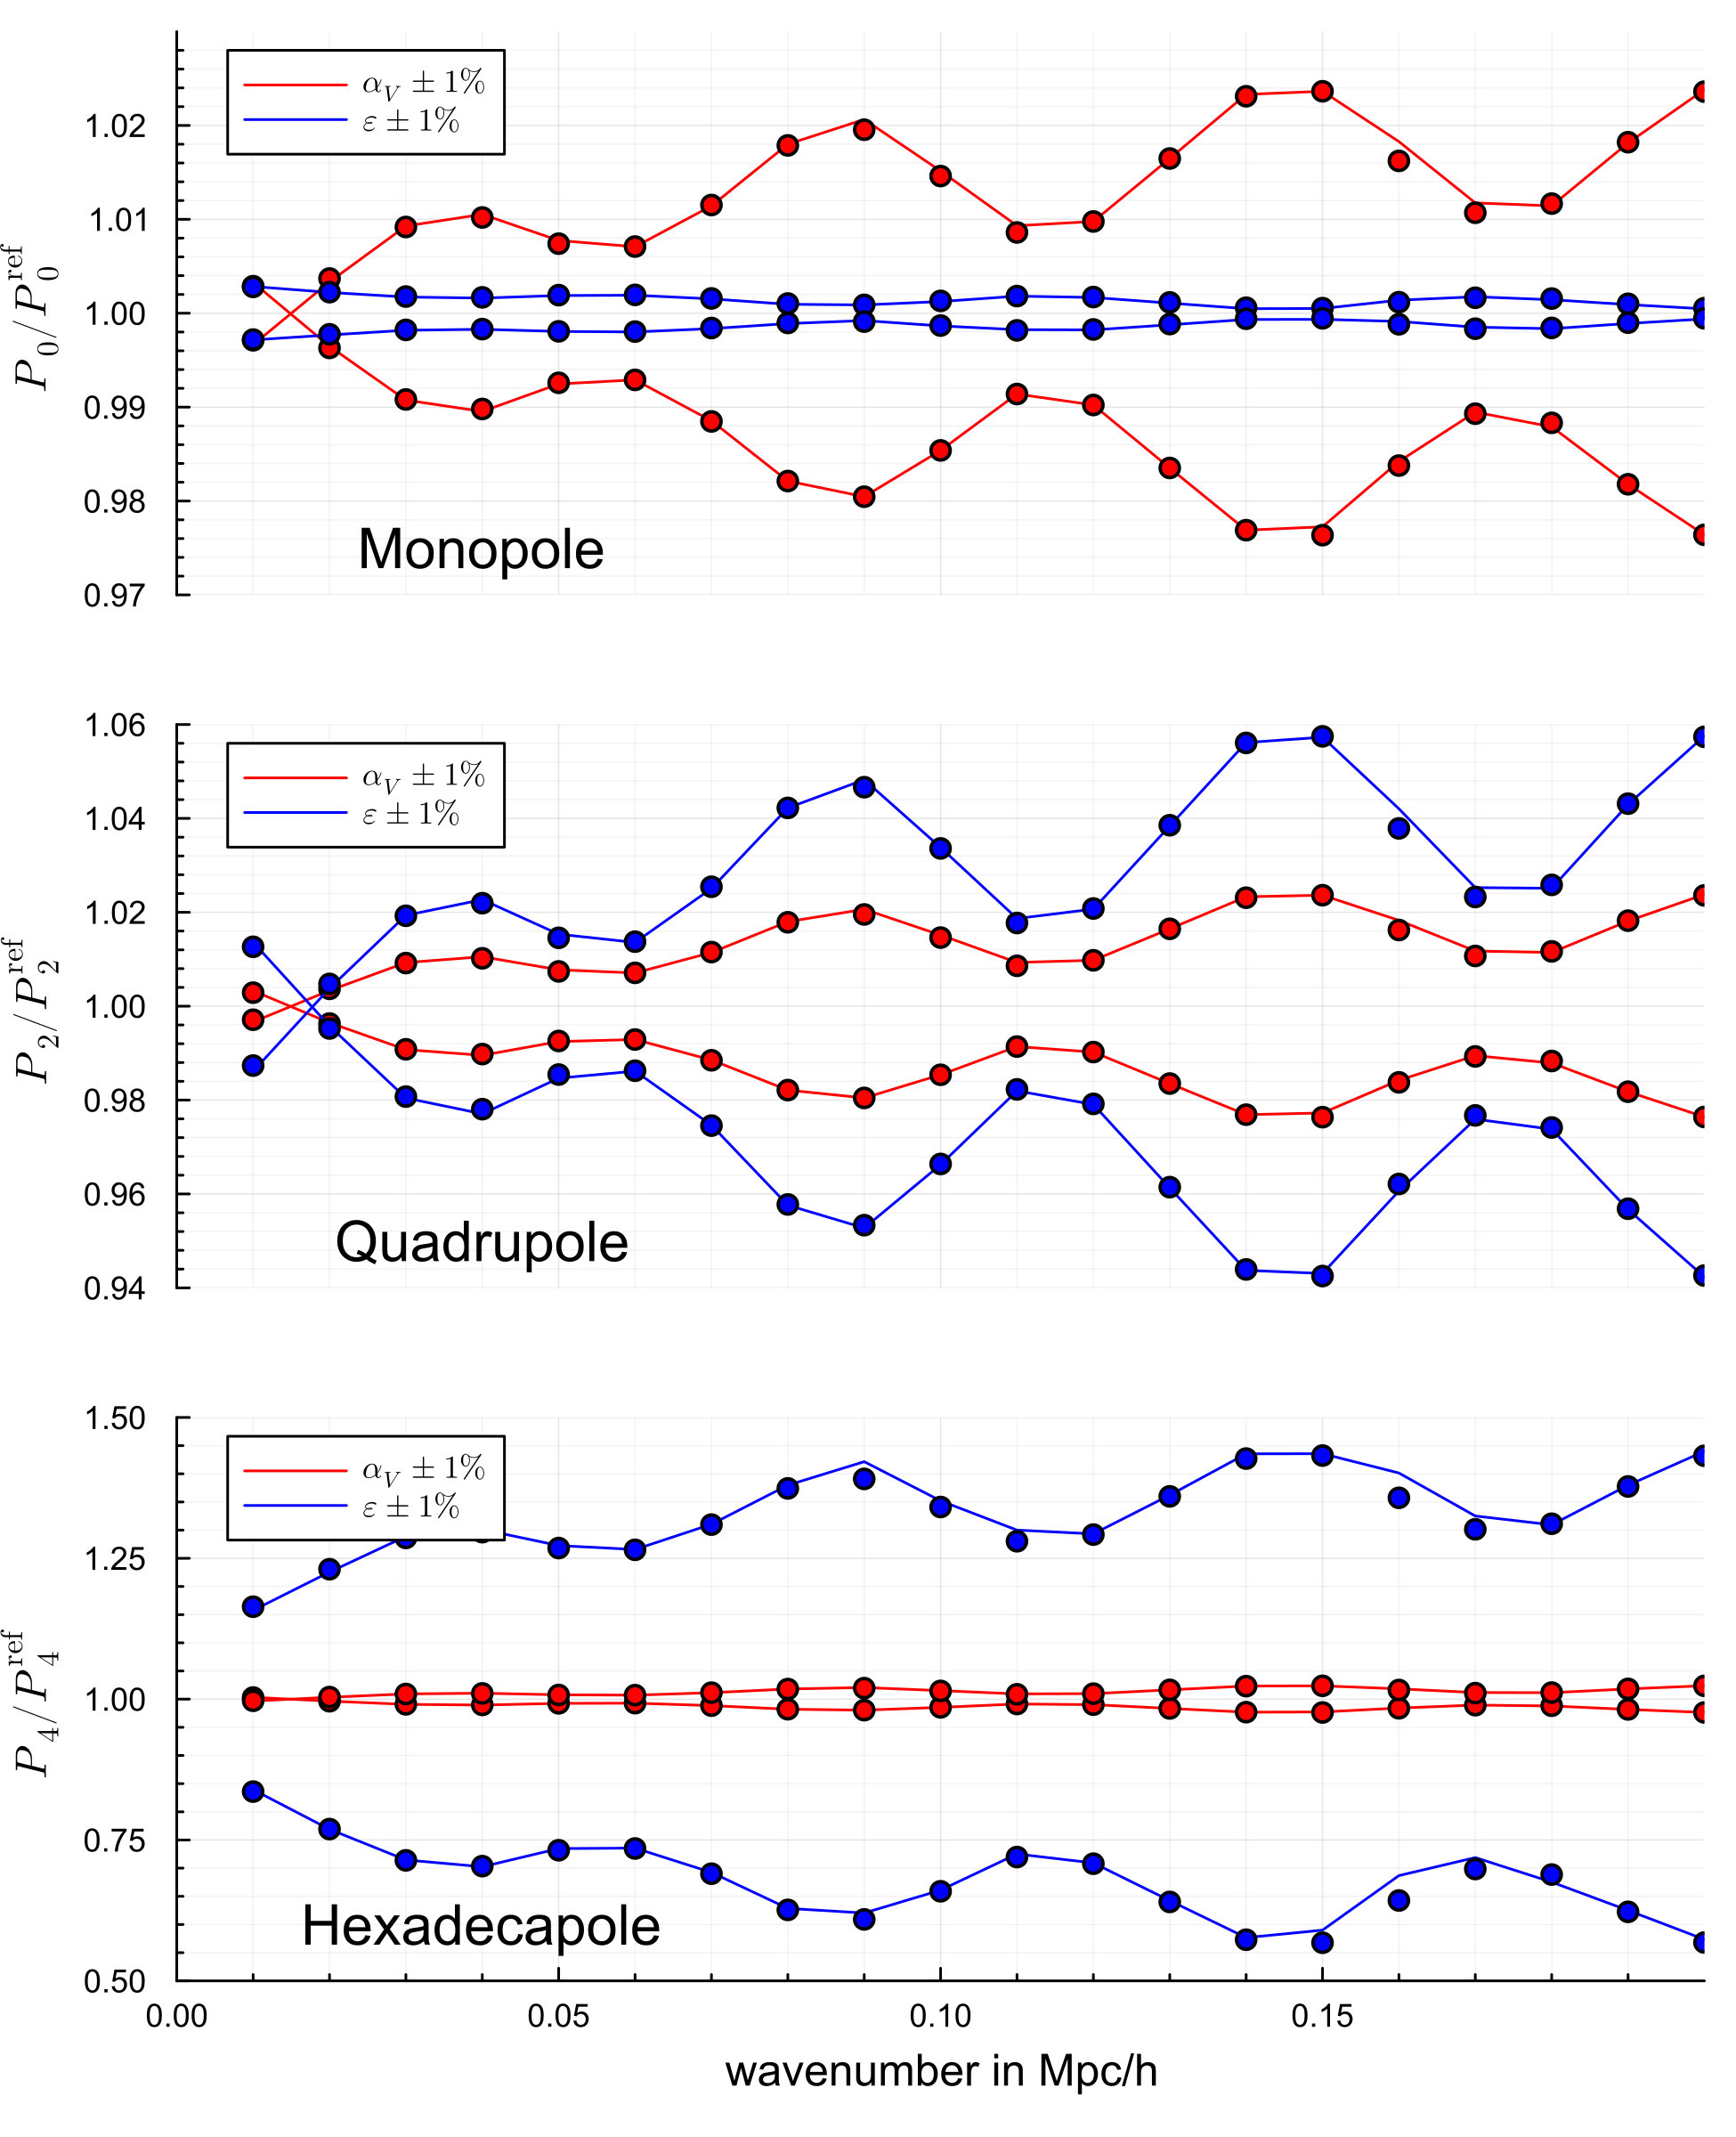

In [31]:
function pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, α, ϵ)
    δα = αV - 1
    δϵ = ϵ - 1
    p0th = p0ref + dp0*δα + (1/5)*dp2*δϵ + (3/5)*p2ref*δϵ
    p2th = p2ref + dp2*δα + (1)*dp0*δϵ + (2/7)*dp2*δϵ + (2/7)*dp4*δϵ + (3/7)*p2ref*δϵ + (10/7)*p4ref*δϵ
    p4th = p4ref + dp4*δα + (18/35)*dp2*δϵ + (20/77)*dp4*δϵ + (-36/35)*p2ref*δϵ + (30/77)*p4ref*δϵ
    return p0th, p2th, p4th
end
αV = 1.01
ϵ = 1.00
p0, p2, p4 = pell(kgrid, αV, ϵ)
p0th, p2th, p4th = pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, αV, ϵ)
plot(kgrid, p0./p0ref, color=:red, label=L"\alpha_V \pm 1\%", layout=(3,1), size=(650, 800), dpi=300)
scatter!(kgrid, p0th./p0ref, color=:red, label=:none, subplot=1, xaxis=:false)
plot!(kgrid, p2./p2ref, color=:red, label=L"\alpha_V \pm 1\%", subplot=2)
scatter!(kgrid, p2th./p2ref, color=:red, label=:none, subplot=2, xaxis=:false)
plot!(kgrid, p4./p4ref, color=:red, label=L"\alpha_V \pm 1\%", subplot=3)
scatter!(kgrid, p4th./p4ref, color=:red, label=:none, subplot=3)
αV = 0.99
ϵ = 1.00
p0, p2, p4 = pell(kgrid, αV, ϵ)
p0th, p2th, p4th = pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, αV, ϵ)
plot!(kgrid, p0./p0ref, color=:red, label=:none, subplot=1)
scatter!(kgrid, p0th./p0ref, color=:red, label=:none, subplot=1)
plot!(kgrid, p2./p2ref, color=:red, label=:none,subplot=2)
scatter!(kgrid, p2th./p2ref, color=:red, label=:none,subplot=2)
plot!(kgrid, p4./p4ref, color=:red, label=:none,subplot=3)
scatter!(kgrid, p4th./p4ref, color=:red, label=:none,subplot=3)
αV = 1.00
ϵ = 1.01
p0, p2, p4 = pell(kgrid, αV, ϵ)
p0th, p2th, p4th = pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, αV, ϵ)
plot!(kgrid, p0./p0ref, color=:blue, label=L"\epsilon \pm 1\%", subplot=1)
scatter!(kgrid, p0th./p0ref, color=:blue, label=:none, subplot=1)
plot!(kgrid, p2./p2ref, color=:blue, label=L"\epsilon \pm 1\%", subplot=2)
scatter!(kgrid, p2th./p2ref, color=:blue, label=:none, subplot=2)
plot!(kgrid, p4./p4ref, color=:blue, label=L"\epsilon \pm 1\%", subplot=3)
scatter!(kgrid, p4th./p4ref, color=:blue, label=:none, subplot=3)
αV = 1.00
ϵ = 0.99
p0, p2, p4 = pell(kgrid, αV, ϵ)
p0th, p2th, p4th = pellth(p0ref, p2ref, p4ref, dp0, dp2, dp4, αV, ϵ)
plot!(kgrid, p0./p0ref, color=:blue, label=:none, legend=:topleft, subplot=1)
scatter!(kgrid, p0th./p0ref, color=:blue, label=:none, subplot=1)
plot!(kgrid, p2./p2ref, color=:blue, label=:none, legend=:topleft, subplot=2)
scatter!(kgrid, p2th./p2ref, color=:blue, label=:none, subplot=2)
plot!(kgrid, p4./p4ref, color=:blue, label=:none, legend=:topleft, subplot=3)
scatter!(kgrid, p4th./p4ref, color=:blue, label=:none, subplot=3)
plot!(xlabel="wavenumber in Mpc/h", ylabel=L"P_4/P^\mathrm{ref}_4", subplot=3)
plot!(ylabel=L"P_2/P^\mathrm{ref}_2", subplot=2)
plot!(ylabel=L"P_0/P^\mathrm{ref}_0", subplot=1)
plot!(xrange=(0,0.20), yrange=(0.97,1.03),grid=true,fontfamily="Arial",minorticks=:true,minorgrid=true, subplot=1)
plot!(xrange=(0,0.20), yrange=(0.94,1.06), yticks=([0.94, 0.96, 0.98, 1.00, 1.02, 1.04, 1.06]), grid=true,fontfamily="Arial",minorticks=:true,minorgrid=true, subplot=2)
plot!(xrange=(0,0.20), yrange=(0.5,1.5),grid=true,fontfamily="Arial",minorticks=:true,minorgrid=true, subplot=3)
annotate!(0.04, 0.975, "Monopole", fontfamily="Arial", subplot=1)
annotate!(0.04, 0.95, "Quadrupole", fontfamily="Arial", subplot=2)
annotate!(0.04, 0.60, "Hexadecapole", fontfamily="Arial", subplot=3)
#savefig("Pap.png")


In [225]:
function solve_triangular_geometry(μ1, ϕ, k1, k2, k3)
    μ12 = (k1^2 + k2^2 - k3^2)/(2*k1*k2)
    μ31 = (k3^2 + k1^2 - k2^2)/(2*k3*k1)
    μ23 = (k2^2 + k3^2 - k1^2)/(2*k2*k3)
    #println(μ12, " ", μ1)
    μ3 = - μ1*μ12 - sqrt(1 - μ1^2)*sqrt(1 - μ12^2)*cos(ϕ)
    μ2 = -(μ1*k1 + μ3*k3)/k2
    return μ2, μ3, μ12, μ23, μ31
end

function tree_level_bk(μ1, ϕ, k1, k2, k3, b1, b2, f, pk)

    #make sure its sorted elsewhere
    #k3, k2, k1 = sort([k1, k2, k3])
    
    pk1 = pk(k1)
    pk2 = pk(k2)
    pk3 = pk(k3)

    μ2, μ3, μ12, μ23, μ31 = solve_triangular_geometry(μ1, ϕ, k1, k2, k3)
 
    Z1k1 = b1 + f*μ1^2
    Z1k2 = b1 + f*μ2^2
    Z1k3 = b1 + f*μ3^2
 
    F12 = 5/7 + μ12/2*(k1/k2 + k2/k1) + 2/7*μ12^2
    F23 = 5/7 + μ23/2*(k2/k3 + k3/k2) + 2/7*μ23^2
    F31 = 5/7 + μ31/2*(k3/k1 + k1/k3) + 2/7*μ31^2
 
    G12 = 3/7 + μ12/2*(k1/k2 + k2/k1) + 4/7*μ12^2
    G23 = 3/7 + μ23/2*(k2/k3 + k3/k2) + 4/7*μ23^2
    G31 = 3/7 + μ31/2*(k3/k1 + k1/k3) + 4/7*μ31^2
 
    Z2k12 = b2/2. + b1*F12 + f*μ3^2*G12
    Z2k12 -= f*μ3*k3/2*(μ1/k1*Z1k2 + μ2/k2*Z1k1)
    Z2k23 = b2/2. + b1*F23 + f*μ1^2*G23
    Z2k23 -= f*μ1*k1/2*(μ2/k2*Z1k3 + μ3/k3*Z1k2)
    Z2k31 = b2/2. + b1*F31 + f*μ2^2*G31
    Z2k31 -= f*μ2*k2/2*(μ3/k3*Z1k1 + μ1/k1*Z1k3)

    Bi = Z2k12*Z1k1*Z1k2*pk1*pk2
    Bi += Z2k23*Z1k2*Z1k3*pk2*pk3
    Bi += Z2k31*Z1k3*Z1k1*pk3*pk1
 
    return 2*Bi 
end

function bk5d(μ, ϕ, k1, k2, k3)
    return tree_level_bk(μ, ϕ, k1, k2, k3, 2, 0.6, 0.7, pk_itp)
end

bk5d (generic function with 1 method)

In [151]:
function k1t(k1, k2, k3, μ, ϕ, αV, ϵ)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    return k1 * sqrt(Apar^2 * μ^2 + Aperp^2 * (1 - μ^2))
end
function k2t(k1, k2, k3, μ, ϕ, αV, ϵ)
    d = (k1^2 + k3^2 - k2^2)/(2*k1)
    r = sqrt(k3^2 - d^2)
    eps1 = atan((r*cos(ϕ))/d)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    theta = acos(μ)
    return sqrt(k2^2 + (Apar-1)^2 * (k1 - k3*sqrt(1 - (r^2 * (sin(ϕ))^2)/k3^2)*(cos(eps1 + theta))^2)^2 + (Aperp-1)^2 * (k1 - k3*sqrt(1 - (r^2 * (sin(ϕ))^2)/k3^2)*(sin(eps1 + theta))^2)^2 + (r^2 * ((Aperp - 1)^2 *sin(ϕ))^2)/k3^2)
end
function k3t(k1, k2, k3, μ, ϕ, αV, ϵ)
    d = (k1^2 + k3^2 - k2^2)/(2*k1)
    r = sqrt(k3^2 - d^2)
    eps1 = atan((r*cos(ϕ))/d)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    theta = acos(μ)
    return  k3 * sqrt((1 - (r^2 * (sin(ϕ))^2)/k3^2)*(((cos(eps1 + theta))^2)*Apar + ((sin(eps1 + theta))^2)*Aperp) + (r^2 * (sin(ϕ))^2 * Aperp )/k3^2)
end
function μt(k1, k2, k3, μ, ϕ, αV, ϵ)
    return μ*αV*ϵ/sqrt(αV^2*ϵ^2*μ^2 + αV^2/ϵ*(1 - μ^2))
end
function ϕt(k1, k2, k3, μ, ϕ, αV, ϵ) 
    d = (k1^2 + k3^2 - k2^2)/(2*k1)
    Aperp = αV/sqrt(ϵ)
    r = sqrt(k3^2 - d^2)
    dt = (k1t(k1, k2, k3, μ, ϕ, αV, ϵ)^2 + k3t(k1, k2, k3, μ, ϕ, αV, ϵ)^2 - k2t(k1, k2, k3, μ, ϕ, αV, ϵ)^2)/(2*k1t(k1, k2, k3, μ, ϕ, αV, ϵ))
    rt = sqrt(k3t(k1, k2, k3, μ, ϕ, αV, ϵ)^2 - dt^2)
    #return asin((r/rt)*sin(ϕ)*Aperp) 
    return ϕ
end

ϕt (generic function with 1 method)

In [308]:
function k1t(k1, k2, k3, μ, ϕ, αV, ϵ)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    ν = sqrt(1 - μ^2)
    k1x = 0
    k1y = k1*ν
    k1z = k1*μ
    return sqrt((k1x^2+k1y^2)*Aperp^2 + k1z^2*Apar^2)
end
function k2t(k1, k2, k3, μ, ϕ, αV, ϵ)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    ν = sqrt(1 - μ^2)
    μ12 = (k1^2+k2^2-k3^2)/k1/k2
    if μ12 > 1
        μ12 = 1
    end
    α12 = acos(μ12)
    k2x = k2*sin(α12)*sin(ϕ)
    k2y = -k2*(μ*cos(ϕ)*sin(α12) - cos(α12)*ν)
    k2z = -k2*(cos(α12)*μ+cos(ϕ)*sin(α12)*ν)
    return sqrt((k2x^2+k2y^2)*Aperp^2 + k2z^2*Apar^2)
end
function k3t(k1, k2, k3, μ, ϕ, αV, ϵ)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    ν = sqrt(1 - μ^2)
    μ31 = (k1^2+k3^2-k2^2)/k1/k3
    if μ31 > 1
        μ31 = 1
    end
    α31 = acos(μ31)
    k3x = -k3*sin(α31)*sin(ϕ)
    k3y = k3*(μ*cos(ϕ)*sin(α31) - cos(α31)*ν)
    k3z = -k3*(cos(α31)*μ+cos(ϕ)*sin(α31)*ν)
    return sqrt((k3x^2+k3y^2)*Aperp^2 + k3z^2*Apar^2)
end
function μt(k1, k2, k3, μ, ϕ, αV, ϵ)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    ν = sqrt(1 - μ^2)
    k1x = 0
    k1y = k1*ν
    k1z = k1*μ
    return k1z*Apar/sqrt((k1x^2+k1y^2)*Aperp^2 + k1z^2*Apar^2)
end
function ϕt(k1, k2, k3, μ, ϕ, αV, ϵ)
    Apar = αV*ϵ
    Aperp = αV/sqrt(ϵ)
    ν = sqrt(1 - μ^2)
    return ϕ
end

ϕt (generic function with 1 method)

In [343]:
(μt(0.1, 0.1, 0.1, 0.1, 1, 1, 1.000001) - μt(0.1, 0.1, 0.1, 0.1, 1, 1, 1))./1e-6

0.1485000337836384

In [325]:
function Y00(x)
    return 1/2/sqrt(π)
end
function Y20(x)
    return sqrt(5)/4/sqrt(π)*(3*x.^2 .-1)
end
function Y40(x)
    return 3/16/sqrt(π)*(35*x.^4 .-30*x.^2 .+3)
end

function bk5d_int(k1, k2, k3, μ, ϕ, αV, ϵ)
    y1 = k1t(k1, k2, k3, μ, ϕ, αV, ϵ)
    y2 = k2t(k1, k2, k3, μ, ϕ, αV, ϵ)
    y3 = k3t(k1, k2, k3, μ, ϕ, αV, ϵ)
    y4 = μt(k1, k2, k3, μ, ϕ, αV, ϵ)
    y5 = ϕ
    return bk5d(y4, y5, y1, y2, y3)
end

function blm(k1, k2, k3, αV, ϵ, W)
    Nk = size(k1)[1]
    pp = zeros(Nk)
    for i in 2:Nk
        pp[i] = hcubature(x -> 
            bk5d_int(k1[i], k2[i], k3[i], x[1], x[2], αV, ϵ)*W(x[1]), [-1, 0], [1, 2*π], reltol=1e-8)[1]
    end
    return pp
end

function b00(k1, k2, k3, αV, ϵ)
    return blm(k1, k2, k3, αV, ϵ, Y00)
end
function b20(k1, k2, k3, αV, ϵ)
    return blm(k1, k2, k3, αV, ϵ, Y20)
end
function b40(k1, k2, k3, αV, ϵ)
    return blm(k1, k2, k3, αV, ϵ, Y40)
end

b40 (generic function with 1 method)

In [335]:
B00fid = b00(kgrid, kgrid, kgrid, 1.00, 1.00);
B00ap = b00(kgrid, kgrid, kgrid, 1.01, 1.00);
B00am = b00(kgrid, kgrid, kgrid, 0.99, 1.00);
B00ep = b00(kgrid, kgrid, kgrid, 1.00, 1.01);
B00em = b00(kgrid, kgrid, kgrid, 1.00, 0.99);
B20fid = b20(kgrid, kgrid, kgrid, 1.00, 1.00);
B20ap = b20(kgrid, kgrid, kgrid, 1.01, 1.00);
B20am = b20(kgrid, kgrid, kgrid, 0.99, 1.00);
B20ep = b20(kgrid, kgrid, kgrid, 1.00, 1.001);
B20em = b20(kgrid, kgrid, kgrid, 1.00, 0.999);
B40fid = b40(kgrid, kgrid, kgrid, 1.00, 1.00);
B40ap = b40(kgrid, kgrid, kgrid, 1.01, 1.00);
B40am = b40(kgrid, kgrid, kgrid, 0.99, 1.00);
B40ep = b40(kgrid, kgrid, kgrid, 1.00, 1.01);
B40em = b40(kgrid, kgrid, kgrid, 1.00, 0.99);


In [327]:
# log derivatives
dB00k1 = (b00(kgrid*(1 + 1e-6), kgrid, kgrid, 1.00, 1.00) .- b00(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB00k2 = (b00(kgrid, kgrid*(1 + 1e-6), kgrid, 1.00, 1.00) .- b00(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB00k3 = (b00(kgrid, kgrid, kgrid*(1 + 1e-6), 1.00, 1.00) .- b00(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB20k1 = (b20(kgrid*(1 + 1e-6), kgrid, kgrid, 1.00, 1.00) .- b20(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB20k2 = (b20(kgrid, kgrid*(1 + 1e-6), kgrid, 1.00, 1.00) .- b20(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB20k3 = (b20(kgrid, kgrid, kgrid*(1 + 1e-6), 1.00, 1.00) .- b20(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB40k1 = (b40(kgrid*(1 + 1e-6), kgrid, kgrid, 1.00, 1.00) .- b40(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB40k2 = (b40(kgrid, kgrid*(1 + 1e-6), kgrid, 1.00, 1.00) .- b40(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;
dB40k3 = (b40(kgrid, kgrid, kgrid*(1 + 1e-6), 1.00, 1.00) .- b40(kgrid, kgrid, kgrid, 1.00, 1.00))/1e-6;

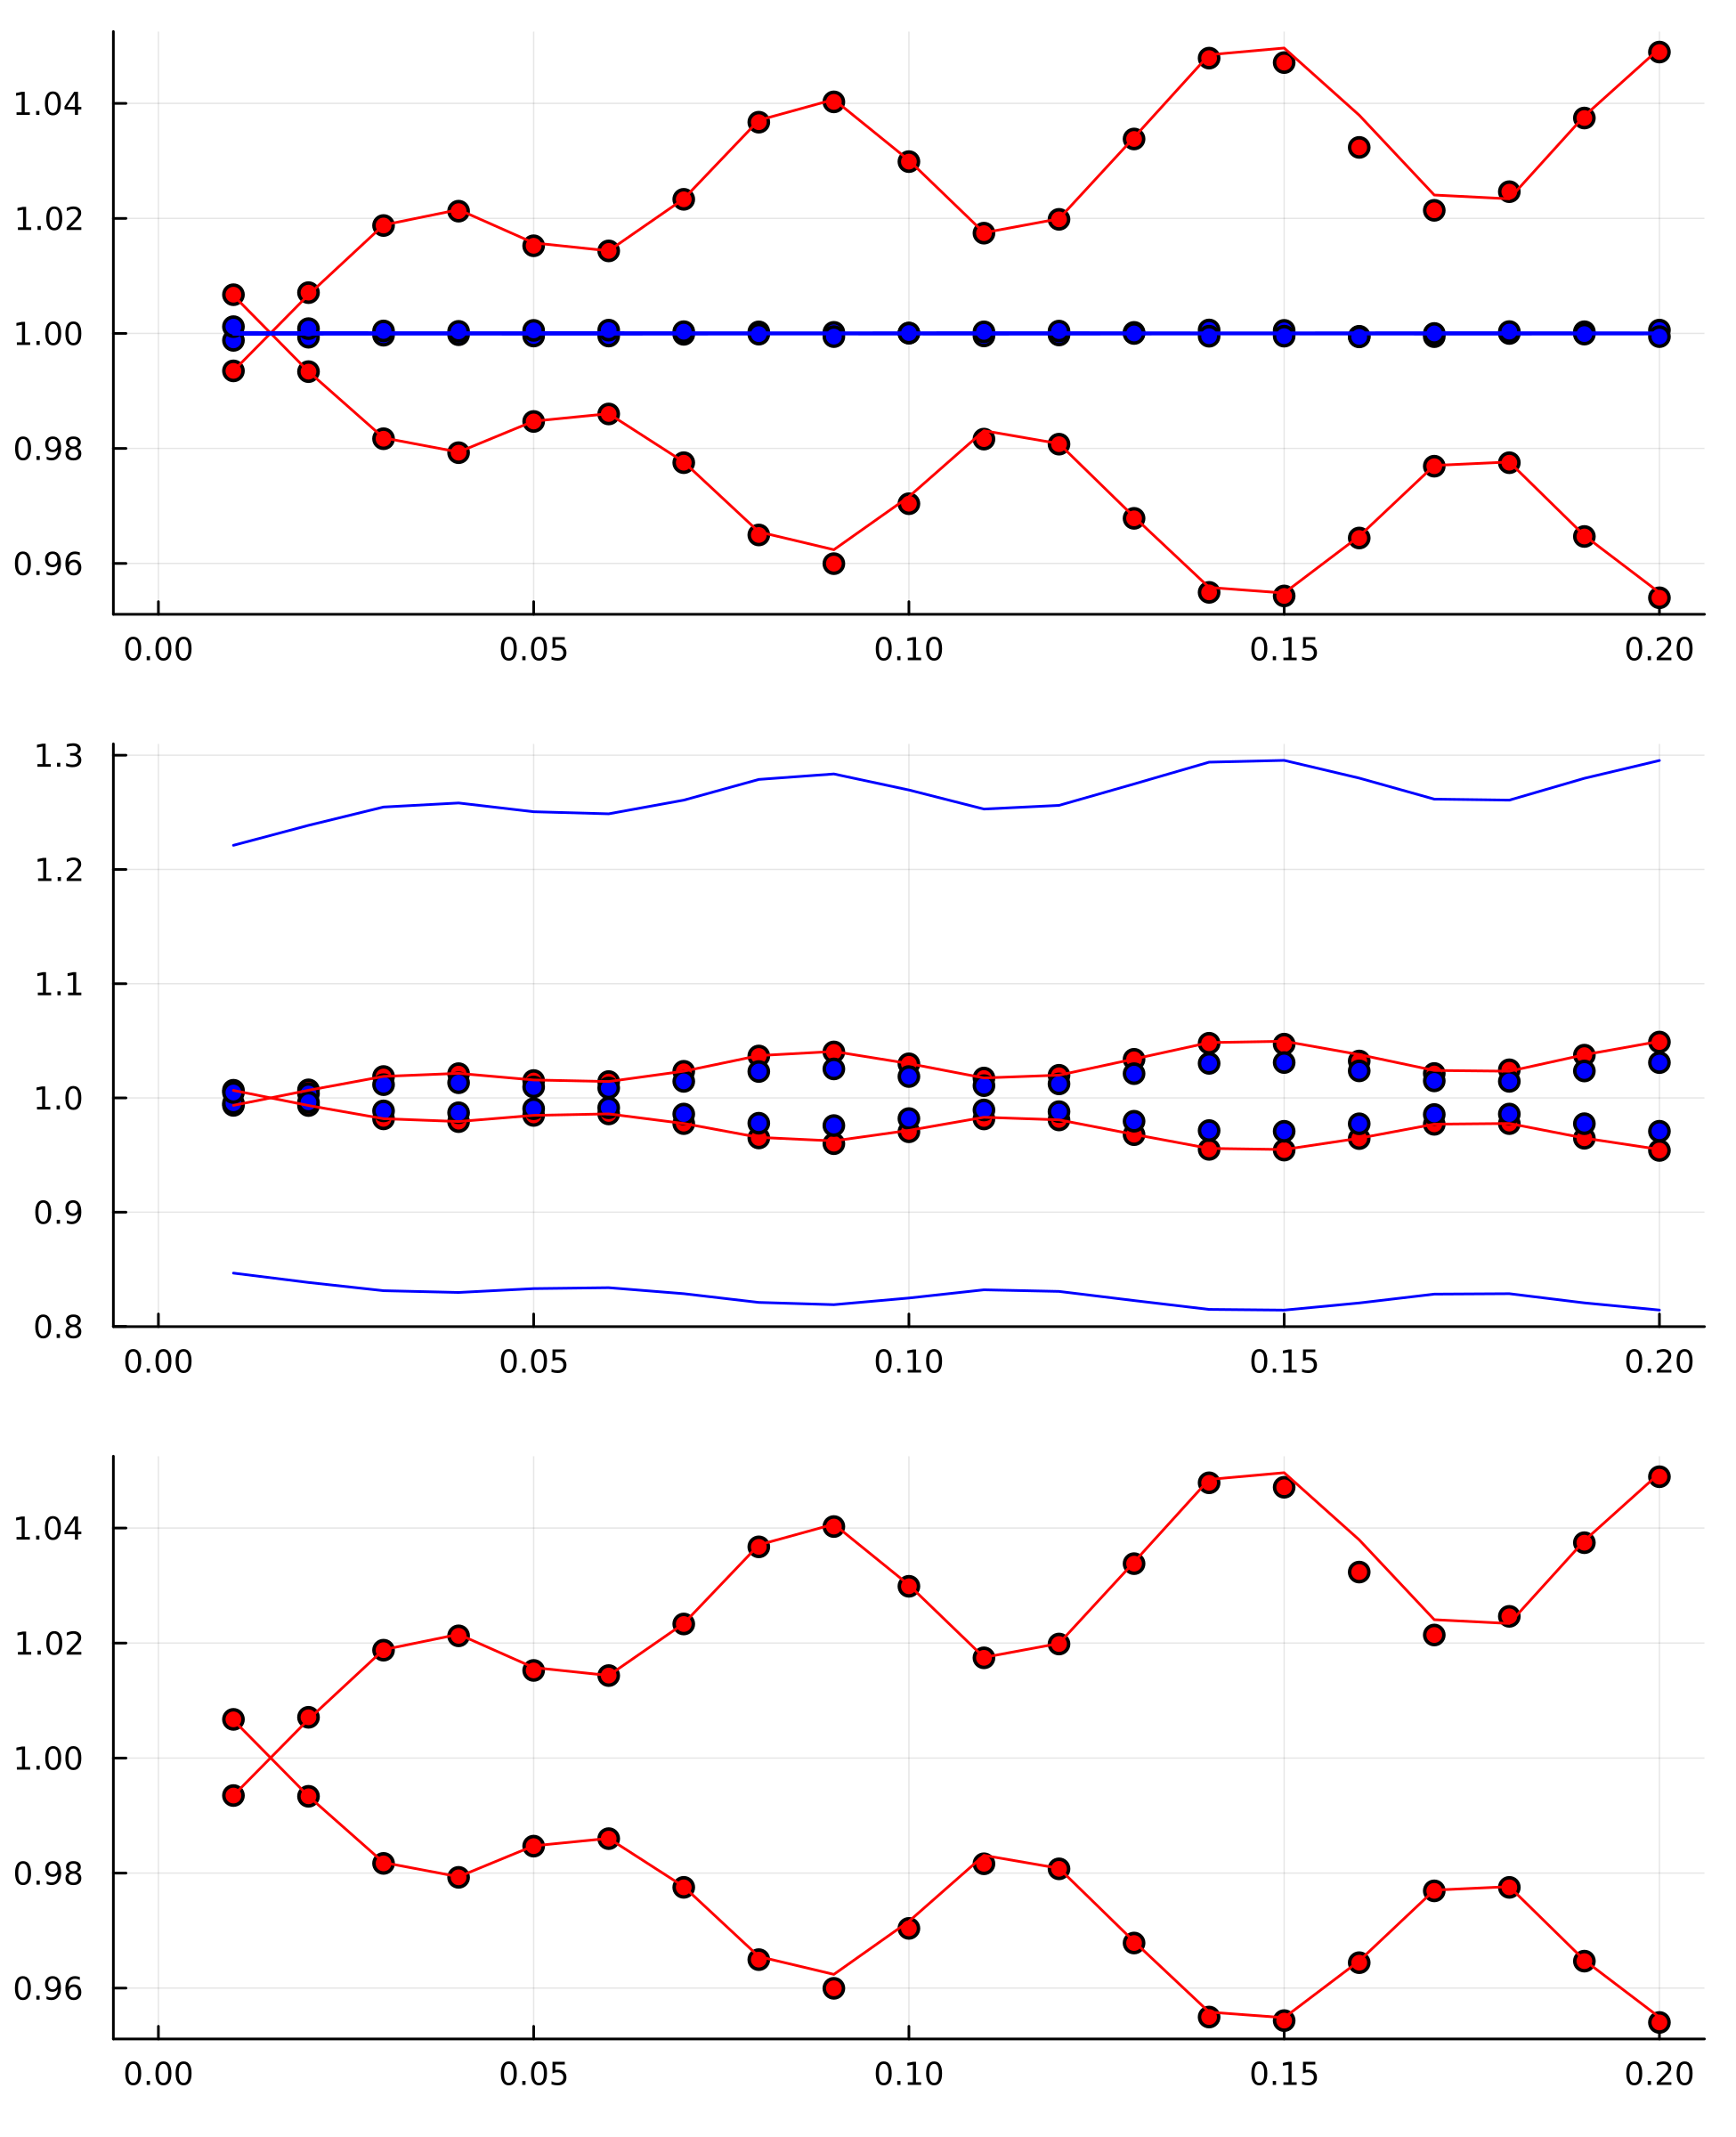

In [353]:
scatter(kgrid, B00fid./B00ap, label=:none, color=:red, layout=(3,1), size=(650, 800), dpi=300, subplot=1)
scatter!(kgrid, B00fid./B00am, label=:none, color=:red, subplot=1)
scatter!(kgrid, B00fid./B00ep, label=:none, color=:blue, subplot=1)
scatter!(kgrid, B00fid./B00em, label=:none, color=:blue, subplot=1)
αV = 1.01; ϵ=1.00
δαV = 1 - αV; δϵ = 1 - ϵ
B00th = B00fid 
B00th += dB00k1*δαV + dB00k2*δαV + dB00k3*δαV
B00th += dB20k1*δϵ/sqrt(5) + dB20k2*δϵ/8/sqrt(5) + dB20k3*δϵ/8/sqrt(5) 
B00th += B20fid*δϵ*3/sqrt(5)
plot!(kgrid, B00fid./B00th, label=:none, color=:red, subplot=1)
αV = 0.99; ϵ=1.00
δαV = 1 - αV; δϵ = 1 - ϵ
B00th = B00fid 
B00th += dB00k1*δαV + dB00k2*δαV + dB00k3*δαV
B00th += dB20k1*δϵ/sqrt(5) + dB20k2*δϵ/8/sqrt(5) + dB20k3*δϵ/8/sqrt(5)  
B00th += B20fid*δϵ*3/sqrt(5)
plot!(kgrid, B00fid./B00th, label=:none, color=:red, subplot=1)
αV = 1.00; ϵ=1.001
δαV = 1 - αV; δϵ = 1 - ϵ
B00th = B00fid .+ dB00k1*δαV + dB00k2*δαV + dB00k3*δαV + dB20k1*δϵ/sqrt(5) + dB20k2*δϵ/8/sqrt(5) + dB20k3*δϵ/8/sqrt(5)  + B20fid*δϵ*3/sqrt(5)
plot!(kgrid, B00fid./B00th, label=:none, color=:blue, subplot=1)
αV = 1.00; ϵ=0.999
δαV = 1 - αV; δϵ = 1 - ϵ
B00th = B00fid .+ dB00k1*δαV + dB00k2*δαV + dB00k3*δαV + dB20k1*δϵ/sqrt(5) + dB20k2*δϵ/8/sqrt(5) + dB20k3*δϵ/8/sqrt(5)  + B20fid*δϵ*3/sqrt(5)
plot!(kgrid, B00fid./B00th, label=:none, color=:blue, subplot=1)
scatter!(kgrid, B20fid./B20ap, label=:none, color=:red, subplot=2)
scatter!(kgrid, B20fid./B20am, label=:none, color=:red, subplot=2)
scatter!(kgrid, B20fid./B20ep, label=:none, color=:blue, subplot=2)
scatter!(kgrid, B20fid./B20em, label=:none, color=:blue, subplot=2)
αV = 1.01; ϵ=1.00
δαV = 1 - αV; δϵ = 1 - ϵ
B20th = B20fid 
B20th += dB20k1*δαV + dB20k2*δαV + dB20k3*δαV
B20th += dB00k1*δϵ*0.2744 + dB20k1*δϵ*(-0.0076699) + dB40k1*δϵ*(0.160785)
B20th += dB00k2*δϵ*(-0.0343) + dB20k2*δϵ*(-0.09558) + dB40k2*δϵ*(-0.0182668)
B20th += dB00k3*δϵ*(-0.0343) + dB20k3*δϵ*(-0.09558) + dB40k3*δϵ*(-0.0182668)
B20th += B00fid*δϵ*(-1.3416) + B20fid*δϵ*(-0.42857) + B40fid*δϵ*0.76665
plot!(kgrid, B20fid./B20th, label=:none, color=:red, subplot=2)
αV = 0.99; ϵ=1.00
δαV = 1 - αV; δϵ = 1 - ϵ
B20th = B20fid 
B20th += dB20k1*δαV + dB20k2*δαV + dB20k3*δαV
B20th += dB00k1*δϵ/sqrt(5) + dB00k2*δϵ/8/sqrt(5) + dB00k3*δϵ/8/sqrt(5) 
B20th += dB20k1*δϵ*2/7 + dB20k2*δϵ/28 + dB20k3*δϵ/28
plot!(kgrid, B20fid./B20th, label=:none, color=:red, subplot=2)
αV = 1.00; ϵ=1.01
δαV = 1 - αV; δϵ = 1 - ϵ
B20th = B20fid 
B20th += dB20k1*δαV + dB20k2*δαV + dB20k3*δαV
B20th += dB00k1*δϵ*0.2744 + dB20k1*δϵ*(-0.0076699) + dB40k1*δϵ*(0.160785)
B20th += dB00k2*δϵ*(-0.0343) + dB20k2*δϵ*(-0.09558) + dB40k2*δϵ*(-0.0182668)
B20th += dB00k3*δϵ*(-0.0343) + dB20k3*δϵ*(-0.09558) + dB40k3*δϵ*(-0.0182668)
B20th += B00fid*δϵ*(-1.3416) + B20fid*δϵ*(-0.42857) + B40fid*δϵ*0.76665
plot!(kgrid, B20fid./B20th, label=:none, color=:blue, subplot=2)
αV = 1.00; ϵ=0.99
δαV = 1 - αV; δϵ = 1 - ϵ
B20th = B20fid 
B20th += dB20k1*δαV + dB20k2*δαV + dB20k3*δαV
B20th += dB00k1*δϵ*0.2744 + dB20k1*δϵ*(-0.0076699) + dB40k1*δϵ*(0.160785)
B20th += dB00k2*δϵ*(-0.0343) + dB20k2*δϵ*(-0.09558) + dB40k2*δϵ*(-0.0182668)
B20th += dB00k3*δϵ*(-0.0343) + dB20k3*δϵ*(-0.09558) + dB40k3*δϵ*(-0.0182668)
B20th += B00fid*δϵ*(-1.3416) + B20fid*δϵ*(-0.42857) + B40fid*δϵ*0.76665
plot!(kgrid, B20fid./B20th, label=:none, color=:blue, subplot=2)
scatter!(kgrid, B40fid./B40ap, label=:none, color=:red, subplot=3)
scatter!(kgrid, B40fid./B40am, label=:none, color=:red, subplot=3)
#scatter!(kgrid, B40fid./B40ep, label=:none, color=:blue, subplot=3)
#scatter!(kgrid, B40fid./B40em, label=:none, color=:blue, subplot=3)
αV = 1.01; ϵ=1.00
δαV = 1 - αV; δϵ = 1 - ϵ
B40th = B40fid 
B40th += dB40k1*δαV + dB40k2*δαV + dB40k3*δαV
plot!(kgrid, B40fid./B40th, label=:none, color=:red, subplot=3)
αV = 0.99; ϵ=1.00
δαV = 1 - αV; δϵ = 1 - ϵ
B40th = B40fid 
B40th += dB40k1*δαV + dB40k2*δαV + dB40k3*δαV
plot!(kgrid, B40fid./B40th, label=:none, color=:red, subplot=3)